In [1]:
!pip install --quiet pandas numpy matplotlib seaborn beautifulsoup4 lxml requests

In [2]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from bs4 import BeautifulSoup
import requests, pathlib, re

In [3]:
def grab_jobs(keyword="Data Scientist", pages=1):
    jobs = []
    for p in range(pages):
        url = (f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/"
               f"search?keywords={keyword}&start={p*25}")
        html = requests.get(url, headers={"User-Agent":"Mozilla/5.0"}).text
        soup = BeautifulSoup(html, "lxml")
        for card in soup.select("li"):
            jobs.append({
                "job_title": card.select_one("h3").text.strip(),
                "company":   card.select_one("h4").text.strip(),
                "city":      card.select_one("span.job-search-card__location").text.strip(),
                "skills":    card.get_text(" ").lower()               # raw text → will clean later
            })
    return pd.DataFrame(jobs)

df = grab_jobs("python developer", pages=2)   # ~50 rows demo
df.head()

,job_title,company,city,skills
0,Python Software Engineer (Fixed Income & Macro),Verition Fund Management LLC,United States,\n \n \n \n \n \n p...
1,Backend Developer (Python),Adapty.io,United States,\n \n \n \n \n \n b...
2,Software Engineer - Python,Selector,"Santa Clara, CA",\n \n \n \n \n \n s...
3,Python Developer,LTIMindtree,"Charlotte, NC",\n \n \n \n \n \n p...
4,Python Developer (Junior),Best Value Technology Incorporated (BVTI),"Maryland, United States",\n \n \n \n \n \n p...


In [4]:
common_skill_words = [
    "python","sql","excel","tableau","aws","power bi","machine learning",
    "communication","java","c++","spark","etl","analytics"
]
def extract_skills(text):
    found = [w.title() for w in common_skill_words if re.search(rf"\b{w}\b", text)]
    return found or ["Other"]

df["skill_list"] = df["skills"].apply(extract_skills)
exploded = df.explode("skill_list")

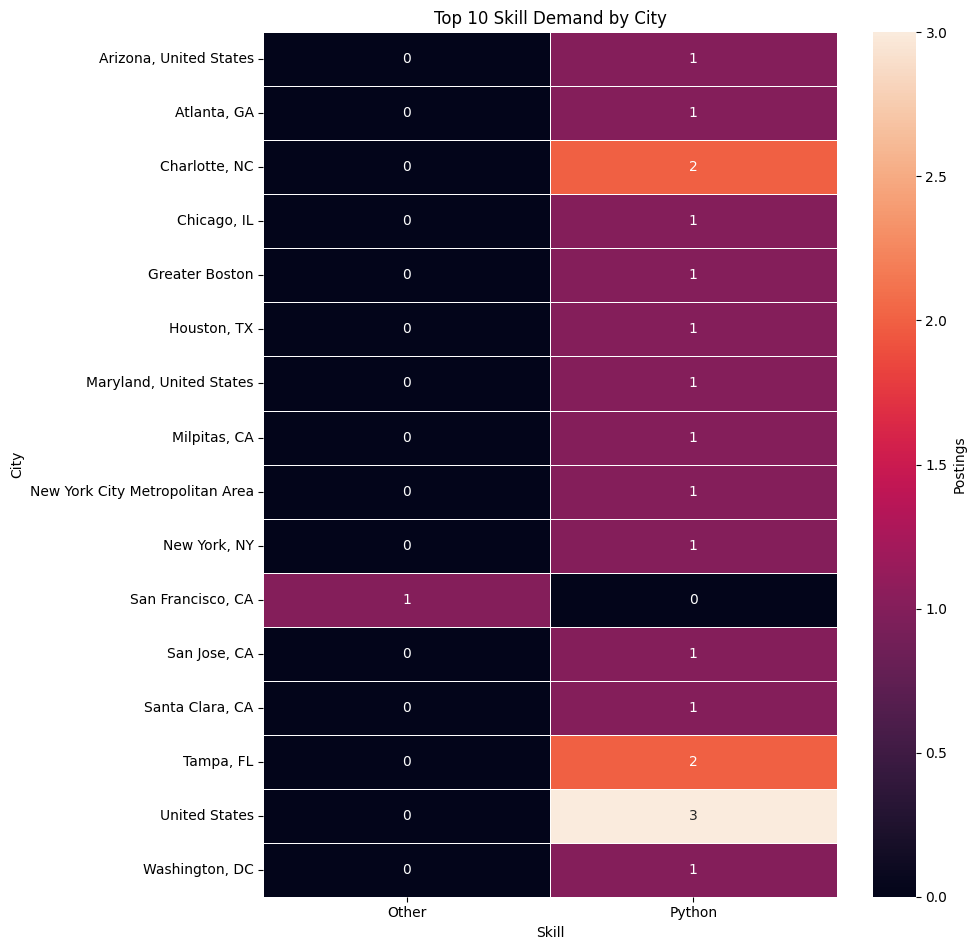

In [6]:
TOP_N = 10

# -- count skills per city & keep each city’s top‑N -------------
top = (
    exploded
      .groupby(["city", "skill_list"])
      .size()
      .groupby(level=0, group_keys=False)   # keep city as level‑0
      .nlargest(TOP_N)                      # top‑N *within* each city
      .reset_index(name="count")            # turn into DataFrame
)

# -- pivot to City × Skill matrix --------------------------------
heat = (
    top.pivot(index="city", columns="skill_list", values="count")
        .fillna(0)
        .astype(int)
        .sort_index()                       # optional: alphabetic city order
)

# -- plot ---------------------------------------------------------
plt.figure(figsize=(10, 0.6 * heat.shape[0]))
sns.heatmap(
    heat,
    annot=True,
    fmt="d",
    linewidths=0.4,
    cbar_kws={"label": "Postings"},
)
plt.title(f"Top {TOP_N} Skill Demand by City")
plt.xlabel("Skill")
plt.ylabel("City")
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
from pathlib import Path

# ---------- 1. Skill × Role matrix → CSV -----------------------------
skill_role = exploded.groupby(["skill_list", "job_title"]).size()
skill_role = skill_role.unstack(fill_value=0)

outfile = Path("skill_role_matrix.csv")
skill_role.to_csv(outfile)
print("✓ Skill‑Role matrix saved as CSV:", outfile)

# ---------- 2. Hot‑skills across cities ------------------------------
cities = top["city"].unique()
needed = int(0.6 * len(cities) + 0.999)   # round up to nearest whole

skill_in_cities = top.groupby("skill_list")["city"].nunique()
hot_skills = skill_in_cities[skill_in_cities >= needed].index.tolist()

print("\n🔥 Hot skills across cities:")
print(", ".join(hot_skills) if hot_skills else "None found")

✓ Skill‑Role matrix saved as CSV: skill_role_matrix.csv

🔥 Hot skills across cities:
Python
